# Detección de neumonía
#### Proyecto: AIRE
#### - Luis Carlos Romero Cardenas.
#### - Maria Camila Plazas Gómez.
#### - Alejandra Gómez.
#### - Santiago. 

## 1. Importar datos

In [2]:
!pip install kagglehub

Solo ejecutar si se requiere descargar las imágenes desde Kaggle

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [08:33<00:00, 4.80MB/s]

Extracting files...


Path to dataset files: C:\Users\Luis Romero\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


### 1.1. Importar librerias

In [22]:
#!pip uninstall numpy -y
#!pip uninstall pandas numpy -y
!pip install numpy==1.26.4 pandas==2.2.2 tensorflow==2.16.1 scikit-learn matplotlib mlflow


  Obtaining dependency information for pandas==2.2.2 from https://files.pythonhosted.org/packages/ab/63/966db1321a0ad55df1d1fe51505d2cdae191b84c907974873817b0a6e849/pandas-2.2.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/3b/dd/9b84302ba85ac6d3d3042d3e8698374838bde1c386b4adb1223d7a0efd4e/pytz-2023.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for waitress<3 from https://files.pythonhosted.org/packages/58/6a/b4b5c582e04e837e4422cab6ec9de7fc10ca7ad7f4e370bb89d280d39552/waitress-2.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for urllib3<2.0.0,>=1.26.7 from https://files.pythonhosted.org/packages/33/cf/8435d5a7159e2a9c83a95896ed596f68cf798005fe107cc655b5c5c14704/urllib3-1.26.20-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/50.1 kB ? eta -:--:--
     ---------------------------------------- 50.1/50.1 kB 2.7 MB/s eta 0:00:00
   ---

In [4]:
#librerias estándar
import os
from collections import Counter

#librerias de manejo de datos
import pandas as pd
import numpy as np

#librerias de deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121


#librerias de visualización
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight


In [5]:

# Ruta completa al conjunto de datos
path=''
data_dir = os.path.join(path, 'Data', 'chest_xray')
data_dir

# Cargar las imágenes desde las carpetas train, test y val
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

# Crear datasets para train, test y val
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    #shuffle=True 
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=False 
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(256, 256),
    batch_size=32
)

print("Datasets cargados exitosamente.")

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Datasets cargados exitosamente.


### 1.2 Determinar el tamaño original de las imágenes.

In [6]:
image_paths = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            image_paths.append(os.path.join(root, file))

# Mostrar dimensiones originales de las primeras 5 imágenes
for path in image_paths[:5]:
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_image(img_raw)
    print(f"{os.path.basename(path)}: {img.shape}")

IM-0115-0001.jpeg: (1858, 2090, 1)
IM-0117-0001.jpeg: (1152, 1422, 1)
IM-0119-0001.jpeg: (1434, 1810, 1)
IM-0122-0001.jpeg: (1279, 1618, 1)
IM-0125-0001.jpeg: (1125, 1600, 1)


Debido al tamaño de promedio de cada imagen y que podría impactar el rendimiento en el entrenamiento del modelo se hará un reescalado de cada imagen a un tamaño estandar de 256 x 256 pixels. Adicional, se evidencia que son imágenes en escala de grises

### 1.3. Muestra de los datos

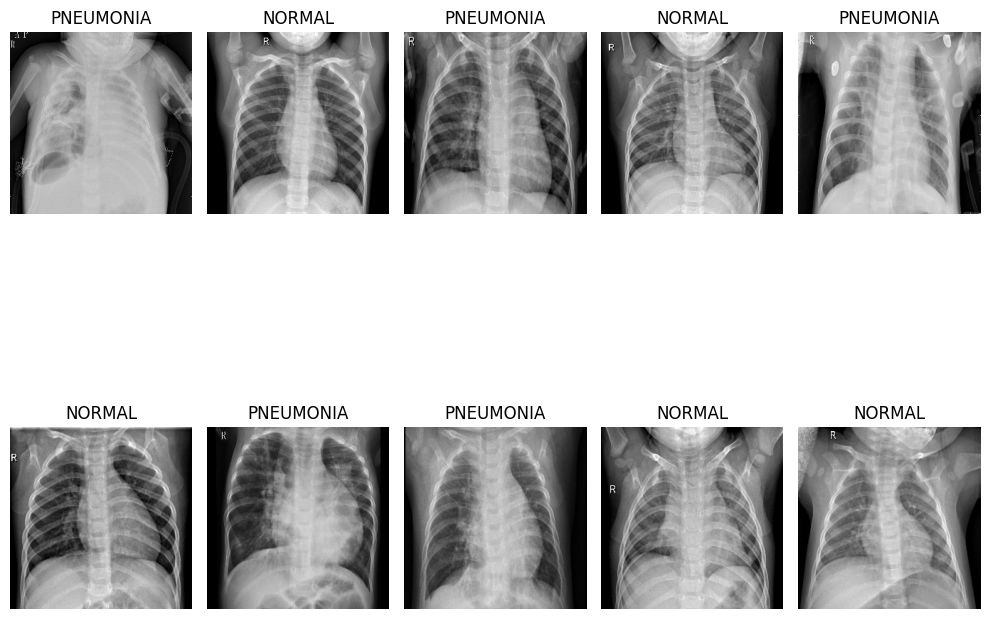

In [7]:

# Obtener las clases del conjunto de entrenamiento
class_names = train_dataset.class_names

# Inicializar contadores para las categorías
category_counts = {class_name: 0 for class_name in class_names}
max_images_per_category = 5

# Crear una lista para almacenar las imágenes y etiquetas
images_to_plot = []
labels_to_plot = []

# Iterar sobre el conjunto de entrenamiento
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if category_counts[class_name] < max_images_per_category:
            images_to_plot.append(image)
            labels_to_plot.append(class_name)
            category_counts[class_name] += 1
        # Romper el bucle si ya tenemos suficientes imágenes
        if all(count >= max_images_per_category for count in category_counts.values()):
            break
    if all(count >= max_images_per_category for count in category_counts.values()):
        break

# Graficar las imágenes
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(images_to_plot, labels_to_plot)):
    plt.subplot(2, max_images_per_category, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

# 2. Preprocesar Datos

### 2.1. Determinar las características del conjunto de datos:


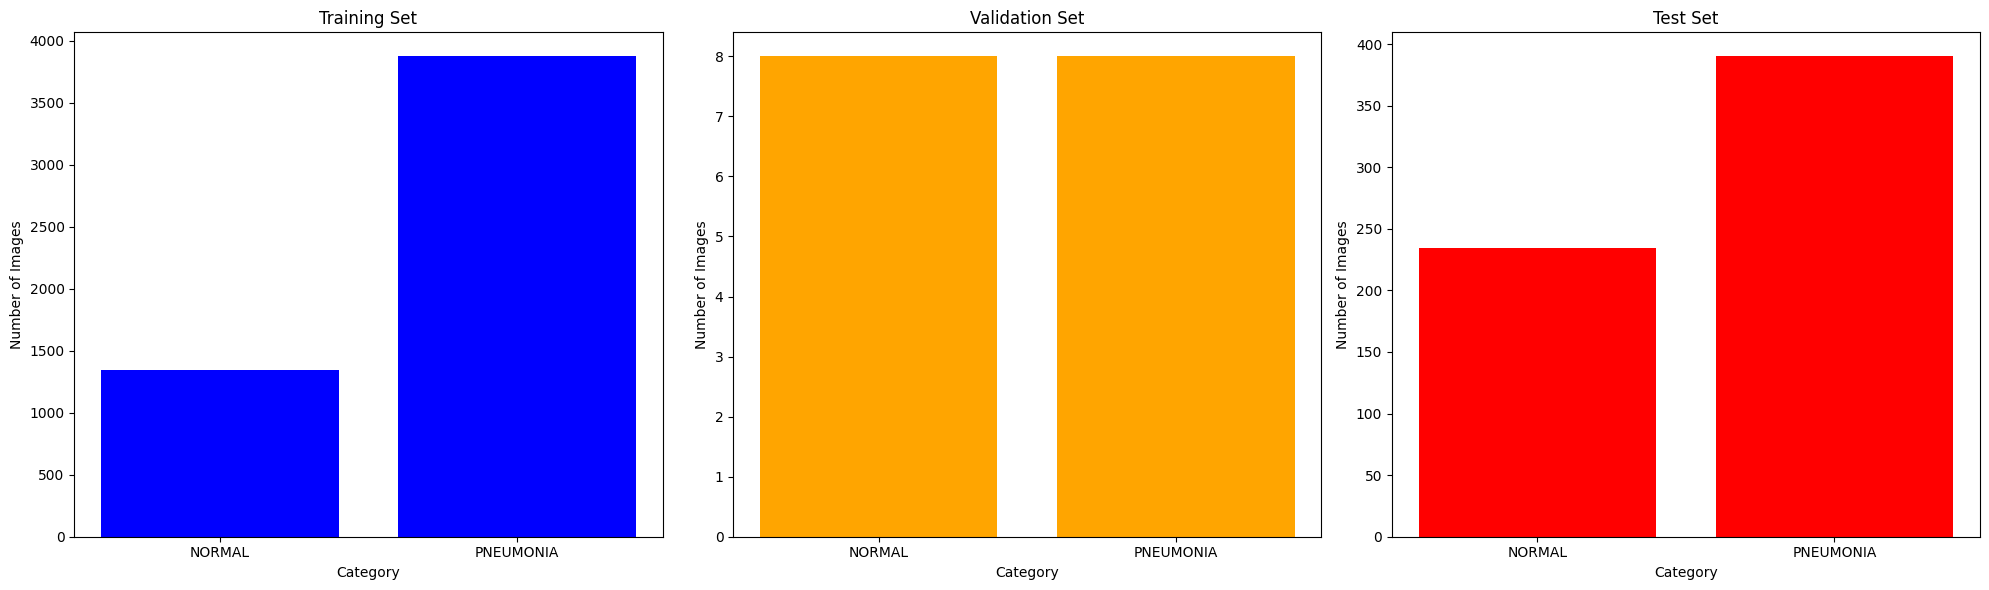

Número de imágenes por categoría en el conjunto de entrenamiento: [1341 3875]
Número de imágenes por categoría en el conjunto de validación: [8 8]
Número de imágenes por categoría en el conjunto de prueba: [234 390]


In [8]:
categories = train_dataset.class_names

# Función para contar las ocurrencias por clase
def count_labels(dataset, num_classes):
    all_labels = []
    for images, labels in dataset:
        all_labels.extend(labels.numpy())
    counts = np.bincount(all_labels, minlength=num_classes)
    return counts

# Obtener los conteos
num_classes = len(categories)
train_counts = count_labels(train_dataset, num_classes)
val_counts = count_labels(val_dataset, num_classes)
test_counts = count_labels(test_dataset, num_classes)

# Crear una figura y ejes
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Gráficos
ax[0].bar(categories, train_counts, color='blue')
ax[0].set_title('Training Set')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Number of Images')

ax[1].bar(categories, val_counts, color='orange')
ax[1].set_title('Validation Set')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Number of Images')

ax[2].bar(categories, test_counts, color='red')
ax[2].set_title('Test Set')
ax[2].set_xlabel('Category')
ax[2].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

print("Número de imágenes por categoría en el conjunto de entrenamiento:", train_counts)
print("Número de imágenes por categoría en el conjunto de validación:", val_counts)
print("Número de imágenes por categoría en el conjunto de prueba:", test_counts)

Se logra evidenciar un desbalanceo del tamaño por cada categoría, en los conjuntos de entrenamiento y prueba. Lo que reuiqre aplicar técnicas para el manejar el desbalanceo y que no afecte el entrenamiento.

### 2.2. Aplicar la técnica de aumento de datos para el conjunto de datos de entrenamiento únicamente:

In [125]:
# Aumento de datos definido como un modelo secuencial
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(0.08),
])

# Cargar dataset desde carpeta
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32
)

# Aplicar el aumento de datos solo al entrenamiento
# (no lo aplicamos a validación ni prueba)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 5216 files belonging to 2 classes.


# 3. Modelo 
### 3.1. Definir parámetros del modelo:

In [12]:
size_filter=(3, 3)
input_shape = (256, 256, 3)
size_classes = len(class_names)
epochs = 30
batch_size = 32
val_image_count = sum([len(files) for r, d, files in os.walk(val_dir) if files])
validation_steps=val_image_count//batch_size
train_image_count = sum([len(files) for r, d, files in os.walk(train_dir) if files])
train_steps=train_image_count//batch_size
test_image_count = sum([len(files) for r, d, files in os.walk(test_dir) if files])
test_steps=test_image_count//batch_size
labels_names = ['NORMAL', 'PNEUMONIA']

### 3.2 Definir el modelo de CNN

In [41]:
model = models.Sequential([
    layers.Conv2D(32,size_filter , activation='relu', input_shape=input_shape,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, size_filter, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, size_filter, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Añadir Dropout con una tasa del 50%
    layers.Dense(size_classes, activation='softmax')
])


### 3.3. Compilar el modelo

In [44]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[
                  'accuracy',
                  metrics.Precision(name='precision'),
                  metrics.Recall(name='recall')
                  ])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

### 3.4.  Entrenar el modelo

In [45]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=epochs
)


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.6957 - loss: 28.9797 - val_accuracy: 0.4375 - val_loss: 1.4235
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4375 - val_loss: 1.4235
Epoch 3/30


c:\ProgramData\anaconda3\envs\mlops\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7857 - loss: 0.8373 - val_accuracy: 0.5000 - val_loss: 2.6420
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.6420
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7774 - loss: 0.8026 - val_accuracy: 0.6250 - val_loss: 1.2000
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 1.2000
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.7782 - loss: 1.0276 - val_accuracy: 0.7500 - val_loss: 0.9236
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.9236
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8026 - loss: 0.7367 - val_accuracy: 0.5625 - val_loss: 1.0156
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0

### 3.4. Evaluar el modelo en el conjunto de prueba

In [56]:

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.4135 - loss: 1.3995
Test accuracy: 0.6682692170143127


### 3.5 Métricas

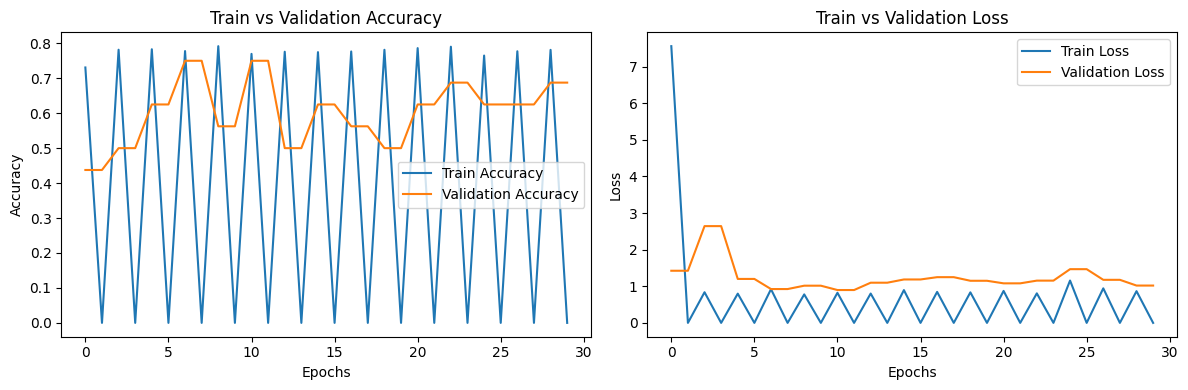

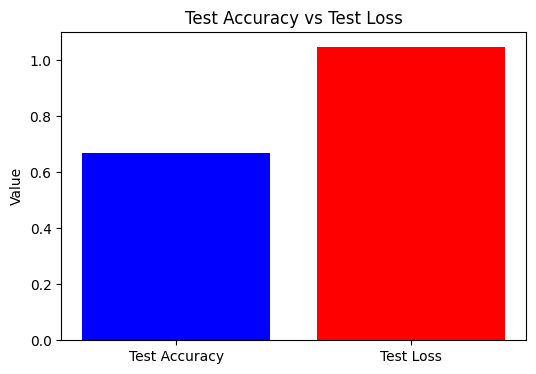

In [57]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


### 3.6 Reporte de clasificación

Longitudes: 624 624


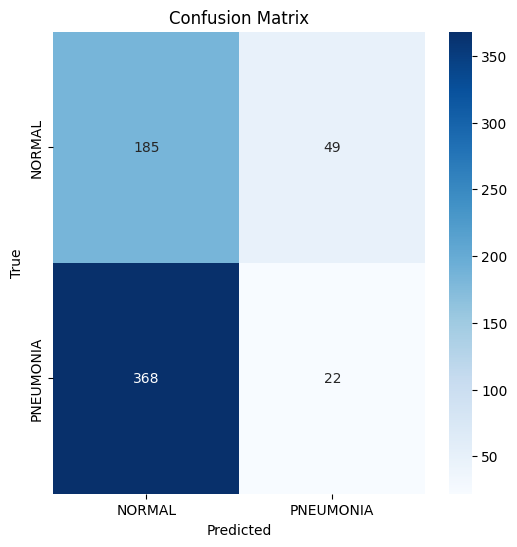

              precision    recall  f1-score   support

      NORMAL       0.33      0.79      0.47       234
   PNEUMONIA       0.31      0.06      0.10       390

    accuracy                           0.33       624
   macro avg       0.32      0.42      0.28       624
weighted avg       0.32      0.33      0.24       624



In [64]:
y_true = []
y_pred = []

for images, labels in test_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)  # convertir (256, 256, 3) -> (1, 256, 256, 3)
    pred = model(image, training=False)     # predicción directa sin .predict()
    y_pred.append(int(pred.numpy().flatten()[0] > 0.5))  # umbral binario
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Longitudes:", len(y_true), len(y_pred))

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

reporte_modelo_1 = classification_report(y_true, y_pred, target_names=labels_names,output_dict=True)
print(classification_report(y_true, y_pred, target_names=labels_names))

#### 3.6.1. Con datos de validación

Longitudes: 16 16


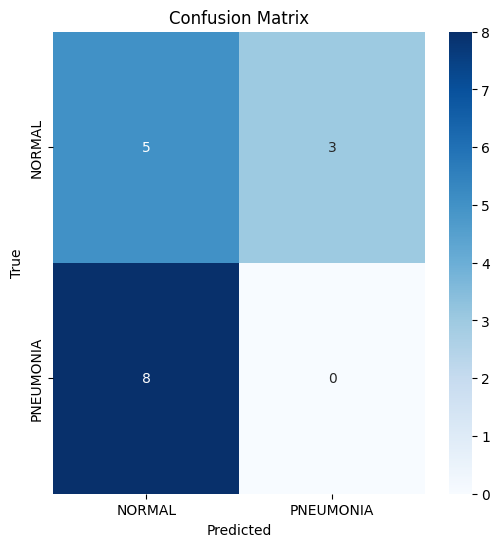

              precision    recall  f1-score   support

      NORMAL       0.38      0.62      0.48         8
   PNEUMONIA       0.00      0.00      0.00         8

    accuracy                           0.31        16
   macro avg       0.19      0.31      0.24        16
weighted avg       0.19      0.31      0.24        16



In [65]:
y_true = []
y_pred = []

for images, labels in val_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)  # convertir (256, 256, 3) -> (1, 256, 256, 3)
    pred = model(image, training=False)     # predicción directa sin .predict()
    y_pred.append(int(pred.numpy().flatten()[0] > 0.5))  # umbral binario
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Longitudes:", len(y_true), len(y_pred))

cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels_names))

### 3.7 Curva ROC
#### 3.7.1 Curva Roc con los datos de test

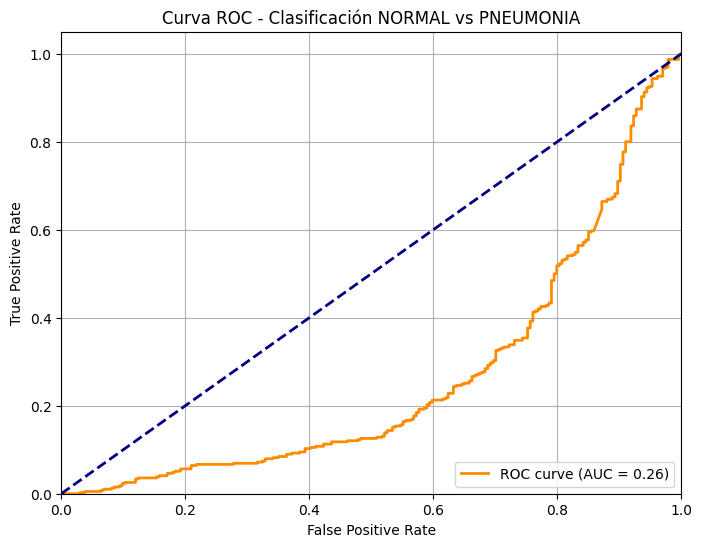

In [67]:
y_true = []
y_pred_prob = []

for images, labels in test_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)
    pred = model(image, training=False).numpy().flatten()[0]
    y_pred_prob.append(pred)
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### 3.7.2 Curva ROC datos de validación

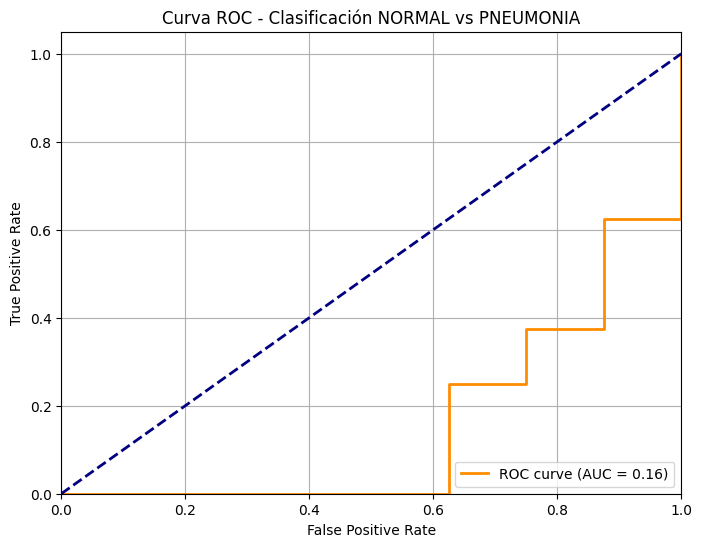

In [68]:
y_true = []
y_pred_prob = []

for images, labels in val_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)
    pred = model(image, training=False).numpy().flatten()[0]
    y_pred_prob.append(pred)
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 3.8 Histograma de distrubución de errores
#### 3.8.1 Distrubución de errores con datos de test

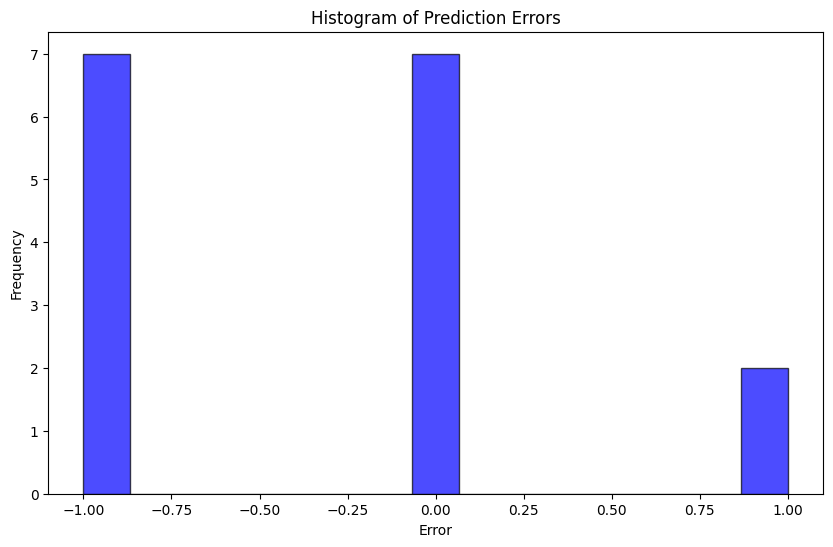

In [69]:
errors = y_pred - y_true

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


### 3.9 Guardar el resultado de las métricas del reporte de clasificación para comparar con los demás modelos

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 4 Modelo 2

### 4.1 Asignación de pesos por desbalanceo de los datos.

In [9]:
class_names = train_dataset.class_names
samples_per_class = {
    "NORMAL": 1341,
    "PNEUMONIA": 3875
}
class_indices = {name: i for i, name in enumerate(class_names)}
y_labels = []
sample_counts = []

for name in class_names:
    y_labels.append(class_indices[name])
    sample_counts.append(samples_per_class[name])

# Calcular pesos balanceados
weights = compute_class_weight(class_weight='balanced', classes=np.array(y_labels), y=np.repeat(y_labels, sample_counts))
class_weights = dict(zip(y_labels, weights))
print("Pesos aplicados:", class_weights)


Pesos aplicados: {0: 1.9448173005219984, 1: 0.6730322580645162}


### 4.2. Modelo preentrenado ResNet, a través de la técnica de Tranfer Learning se hace proceso de fine tunning.

#### **Arquitectura:** Introduce los "residual blocks" con skip connections (conexiones de salto).

#### **Ejemplo:** ResNet50, ResNet101, ResNet152

#### **Ventaja:** Entrena redes muy profundas evitando el problema del desvanecimiento del gradiente.

#### **Clave:** Aprende solo la diferencia ("residuo") entre entrada y salida de cada bloque.

In [10]:
# Carga de la ResNet50 preentrenada (sin la última capa)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model.trainable = False  # Congelar pesos

# Construcción del modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


## 4.3 Resumen del modelo.

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 4.4 Compilado y entrenamiento del modelo.

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - loss: 0.4052 - sparse_categorical_accuracy: 0.8254 - val_loss: 0.2630 - val_sparse_categorical_accuracy: 0.8125
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - loss: 0.1374 - sparse_categorical_accuracy: 0.9434 - val_loss: 0.1254 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - loss: 0.1166 - sparse_categorical_accuracy: 0.9466 - val_loss: 0.1628 - val_sparse_categorical_accuracy: 0.9375
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9612 - val_loss: 0.1294 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.0797 - val_sparse_categorical_accuracy: 0.9375
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0863 - val_sparse_categorical_accuracy: 0.937

## 4.5. Gráficos del comportamiento del modelo durante el entrenamiento.

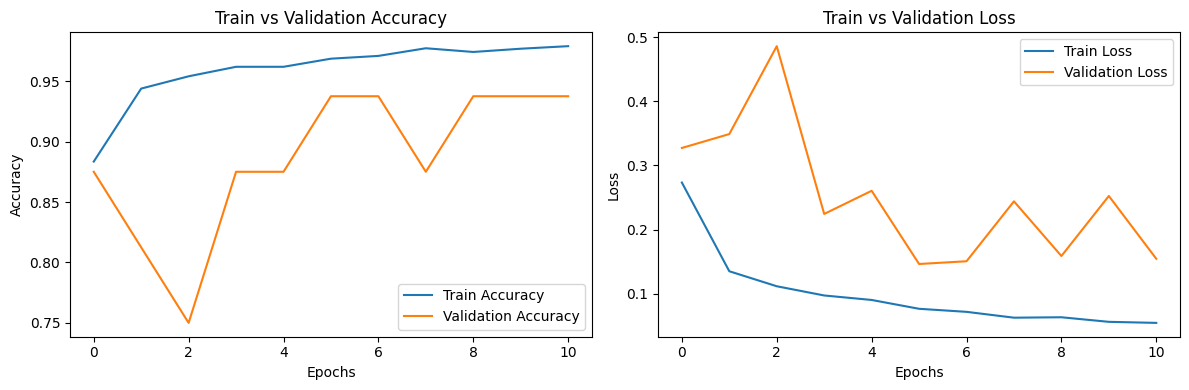

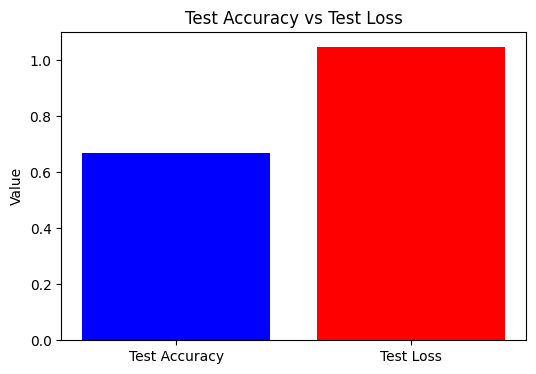

In [136]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


## 4.6. Predicción con los datos de test

In [151]:
# Evaluación después de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━

## 4.7. Matriz de confusión datos de test


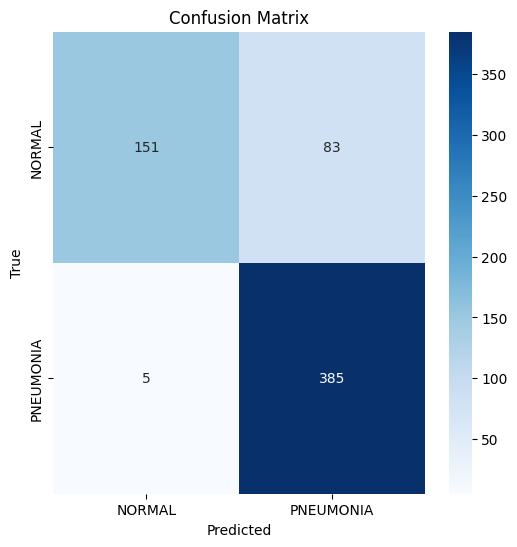

In [152]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 4.8. Predicción con los datos de validación.

In [153]:
# Evaluación después de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      0.88      0.93         8
   PNEUMONIA       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



## 4.9. Matriz de confusión con los datos de validación

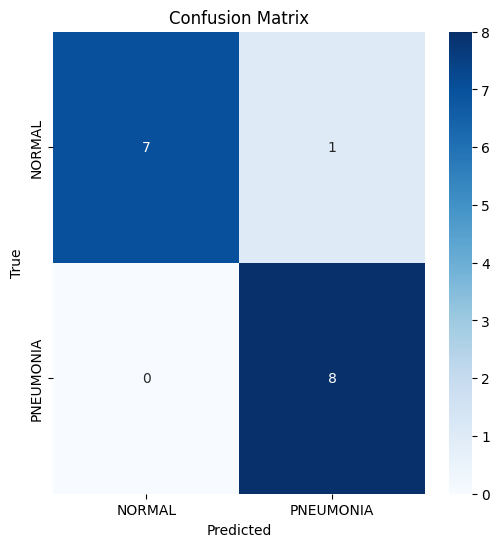

In [154]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 4.10. Curva ROC
### 4.10.1 Curva ROC con los datos de test.

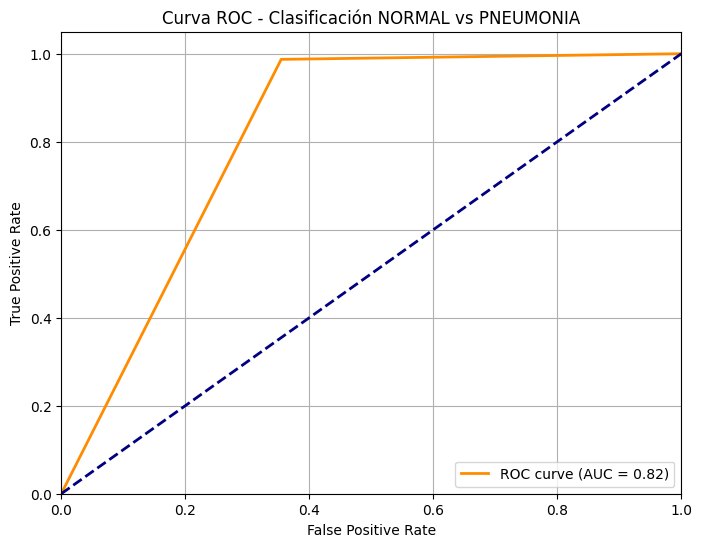

In [155]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 4.10.2. Curva ROC con los datos de validación.

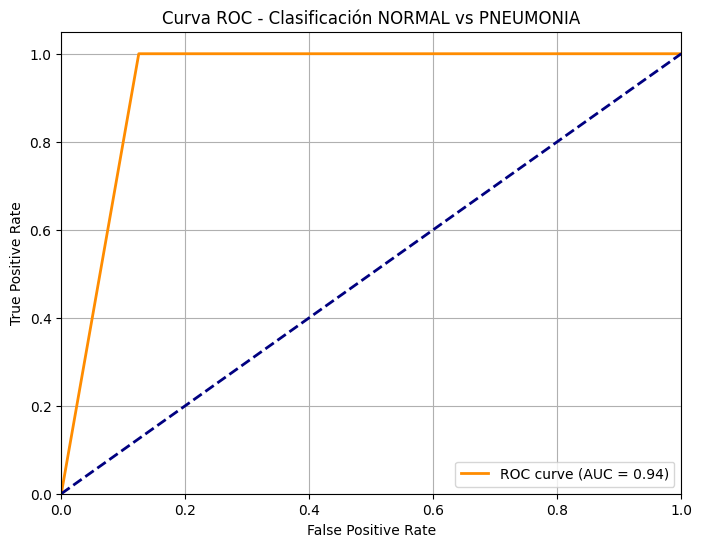

In [156]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 4.11. Diagrama de distribución de errores.
### 4.11.1 Distribución de errores con los datos de test.

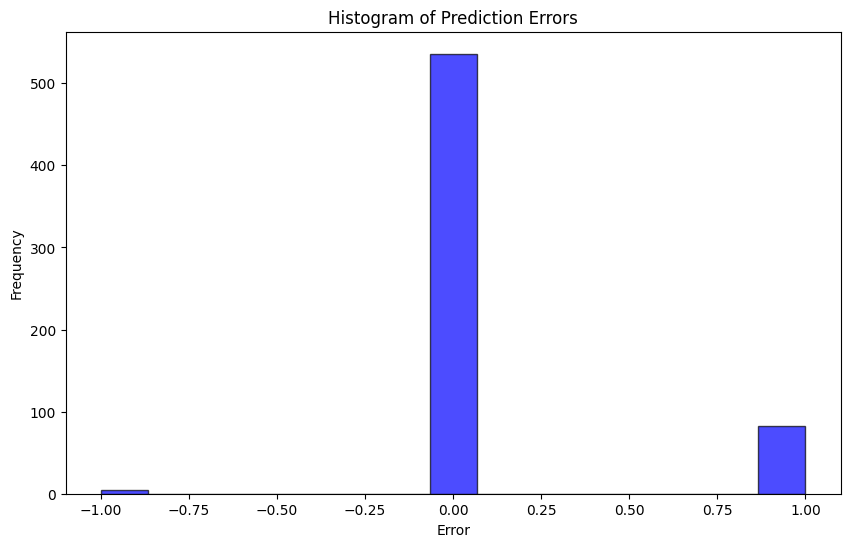

In [158]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

### 4.11.2 Distribución de errores con los datos de validación.

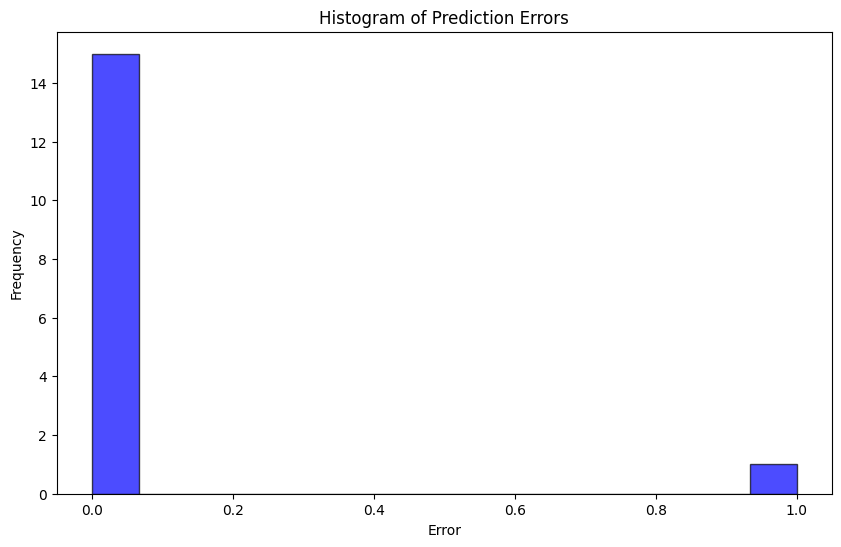

In [159]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 5 Modelo 3 - VGGNet 16.

#### **Arquitectura:** Muy simple y secuencial. Solo usa capas Conv3x3 + MaxPooling + Dense.

#### **Ejemplo:** VGG16, VGG19

#### **Ventaja:** Fácil de entender e implementar.

#### **Desventaja:** Muy pesado (muchos parámetros), lento y sin atajos para el flujo de información.

## 5.1 Modelo.

In [14]:
base_model_vgg = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_vgg.trainable = False  # Congelar la base

# Construir modelo
model_3 = models.Sequential([
    base_model_vgg,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 clases
])

## 5.2 Resumen del modelo.

In [15]:
model_3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## 5.3 Compilado del modelo.

In [16]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

## 5.4 Entrenamiento del modelo. 

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model_3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - loss: 1.5314 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.0010 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - loss: 0.0859 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.0621 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0107 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0104 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.0046 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - loss: 0.0234 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.0934 - val_sparse_categorical_accuracy: 0.937

## 5.5 Evaluar el modelo con los datos de test

In [20]:
test_loss, test_acc = model_3.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - loss: 1.1167 - sparse_categorical_accuracy: 0.8204
Test accuracy: 0.8830128312110901


## 5.6. Resultados del comportamiento del modelo durante el proceso de entrenamiento.

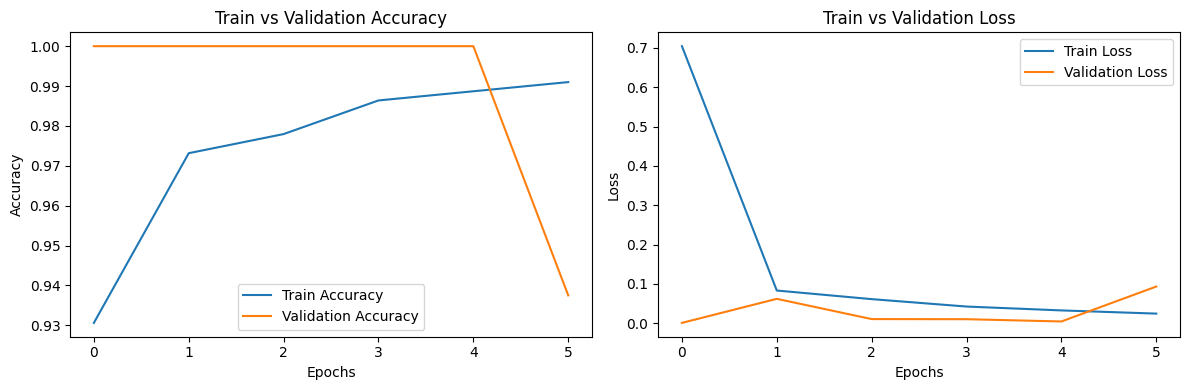

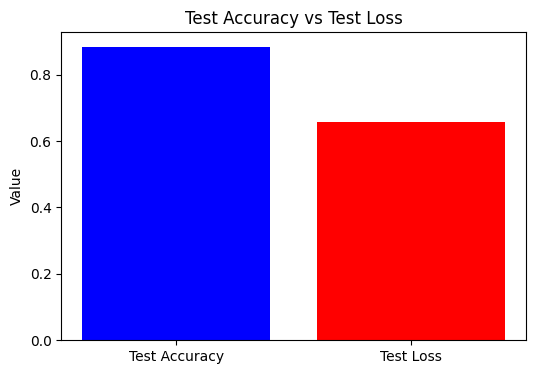

In [22]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


## 5.7. Predicción del modelo con los datos de test.

In [21]:
# Evaluación después de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model_3.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## 5.8 Matriz de confusión con los datos de test.

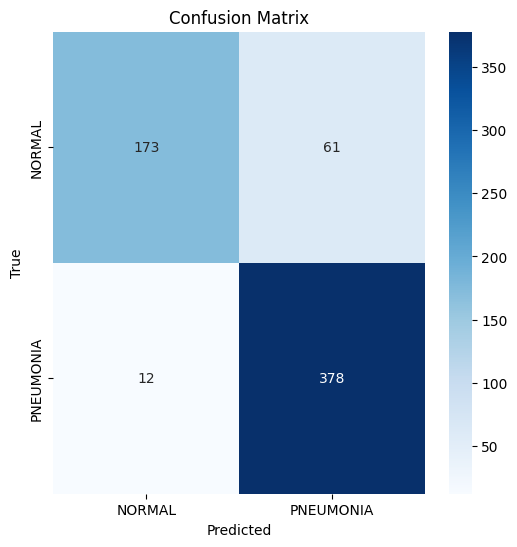

In [23]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 5.9. Predicción del modelo con los datos de validación.

In [25]:
# Evaluación después de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model_3.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



## 5.10. Matriz de confusión con los datos de validación.

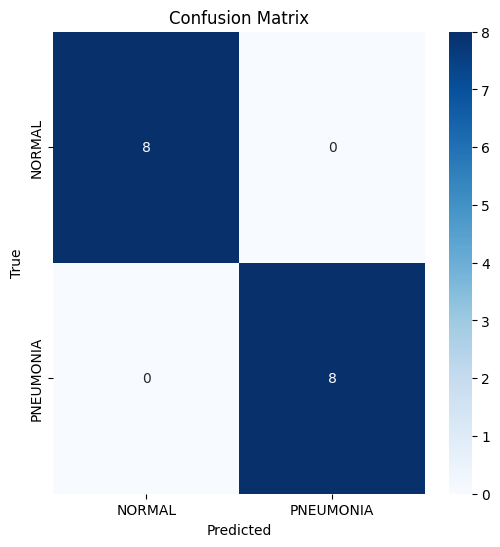

In [26]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 5.11. Curva ROC.
### 5.11.1 Curva ROC con los datos de entrenamiento.

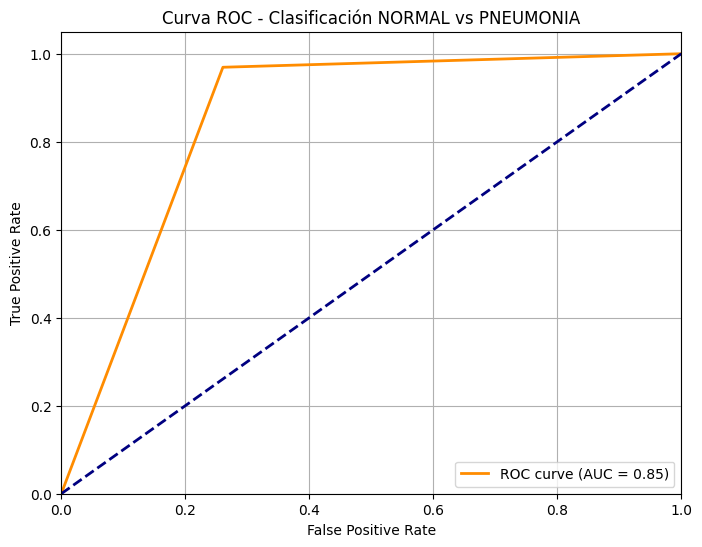

In [27]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 5.11.2. Curva ROC con los datos de validación.

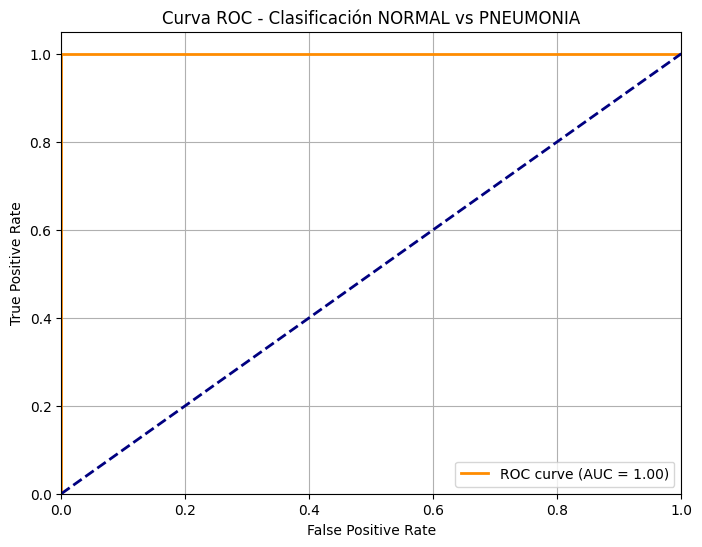

In [28]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 5.12 Histograma de distribución de errores.
### 5.12.1 distribución de errores con los datos de test.

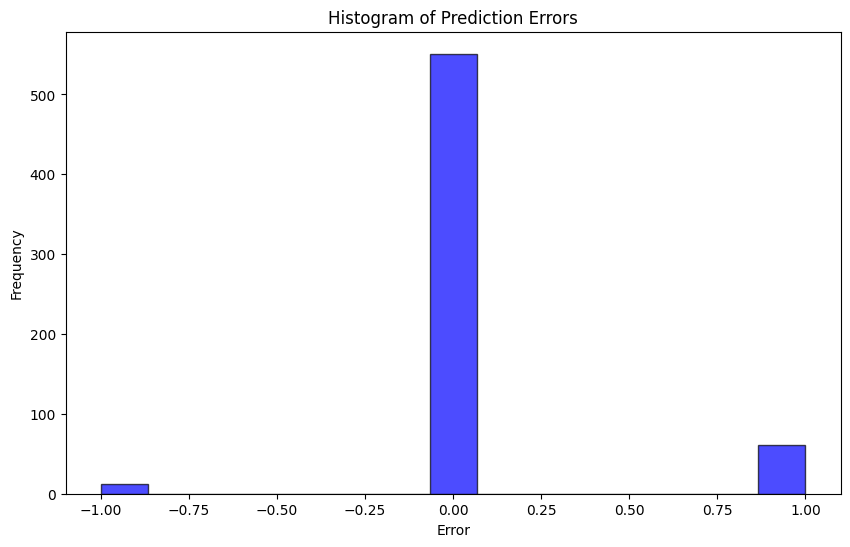

In [29]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

### 5.12.2 Distribución de errores con los datos de validación.

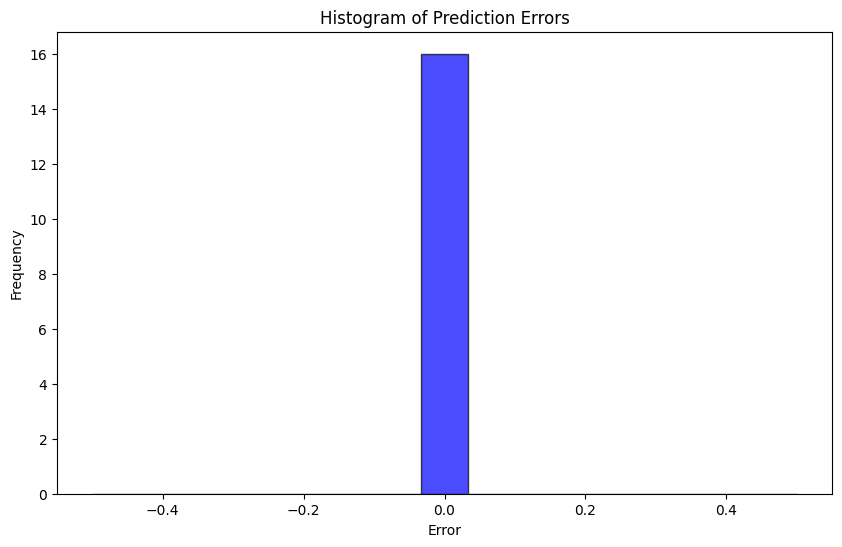

In [30]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

In [72]:
# Guarda el modelo completo (arquitectura + pesos + optimizer)
#model_3.save('modelo_VGGNet16.h5')
# Guarda el modelo como carpeta con archivos de metadatos
#model_3.save('modelo_VGGNet16F.h5')  # crea una carpeta
# Útil si ya tienes la arquitectura definida por código
model_3.save_weights('pesos_VGGNet16.weights.h5')
# Guarda como SavedModel (crea una carpeta con todos los archivos)
tf.saved_model.save(model_3, "modelo_VGGNet16F")




INFO:tensorflow:Assets written to: modelo_VGGNet16F\assets


INFO:tensorflow:Assets written to: modelo_VGGNet16F\assets


In [74]:
from keras.layers import TFSMLayer

# Cargar como capa para predicción
modelo_inferencia = TFSMLayer("modelo_VGGNet16F", call_endpoint="serving_default")


In [80]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing import image
def predecir_con_savedmodel(modelo_inferencia, ruta_imagen, class_names):
    
    img = image.load_img(ruta_imagen, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalización

    pred = modelo_inferencia(img_array)
    pred_tensor = pred['output_0']
    clase = class_names[np.argmax(pred_tensor, axis=1)[0]]
    return clase

pred = predecir_con_savedmodel(modelo_inferencia, "IP2.jpeg", ['NORMAL', 'PNEUMONIA'])
print("Clase predicha:", pred)


Clase predicha: PNEUMONIA


In [77]:
pred

{'output_0': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.21333274, 0.7866672 ]], dtype=float32)>}

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 6. Modelo 4 DesNet
#### **Arquitectura:** Cada capa está conectada con todas las anteriores.

#### **Ejemplo:** DenseNet121, DenseNet169

#### **Ventaja:** Mejor reutilización de características, menos parámetros y mejora del flujo de gradiente.

#### **Clave:** Cada capa recibe como entrada la salida de todas las capas anteriores (concatenación).
## 6.1. Se aplican técnica de data aumentation para entrenar el modelo con más datos e intentar mejorar las métricas resultado.

In [48]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'  
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 6.2 Modelo

In [43]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False  # congelar pesos preentrenados

# Construir el modelo final
model_dn = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_weights), activation='softmax')  # para N clases
])

## 6.3 Resumen del modelo.

In [44]:
model_dn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

## 6.4. Compilado y entrenamiento del modelo.

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_dn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

history_dn = model_dn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - loss: 0.6380 - sparse_categorical_accuracy: 0.6913 - val_loss: 0.3615 - val_sparse_categorical_accuracy: 0.8750
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - loss: 0.2854 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.3339 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - loss: 0.2383 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.2578 - val_sparse_categorical_accuracy: 0.9375
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - loss: 0.2117 - sparse_categorical_accuracy: 0.9143 - val_loss: 0.2403 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - loss: 0.1929 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.2330 - val_sparse_categorical_accuracy: 0.9375
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - loss: 0.1848 - sparse_categorical_accuracy: 0.9249 - val_loss: 0.2143 - val_sparse_categorical_accuracy: 0.937

## 6.5. Evaluación del modelo con los datos de test

In [49]:
test_loss, test_acc = model_dn.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 15.9495 - sparse_categorical_accuracy: 0.2984
Test accuracy: 0.625


## 6.6. Gráficos de comportamiento del modelo durante el entrenamiento.

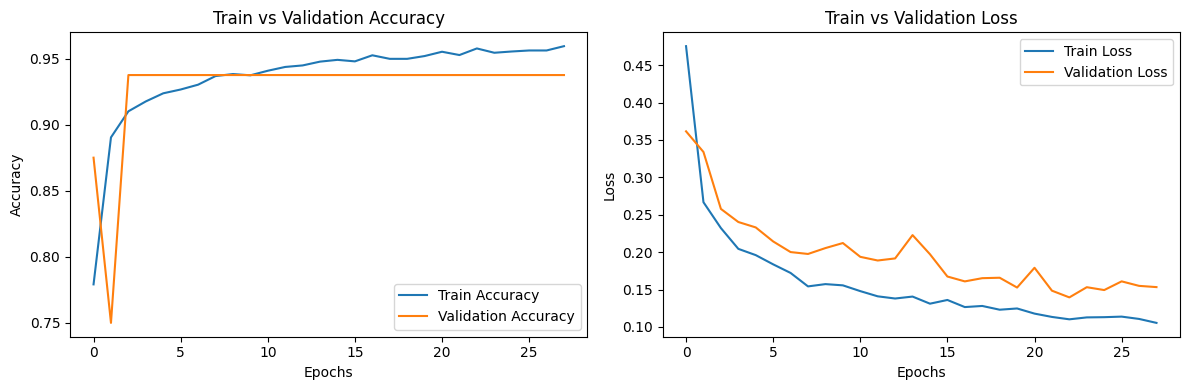

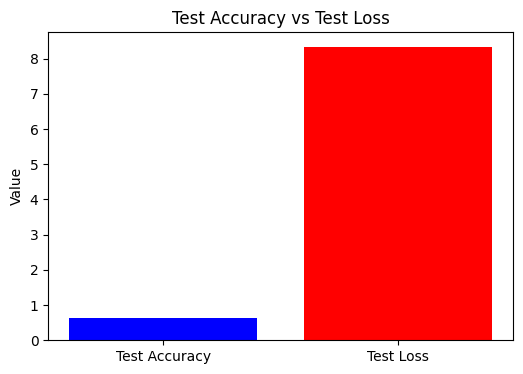

In [50]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dn.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_dn.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_dn.history['loss'], label='Train Loss')
plt.plot(history_dn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


## 6.7. Predicción del modelo con los datos de test.

In [51]:
# Evaluación después de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model_dn.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_dn_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

## 6.8. Matriz de confusión datos de test. 

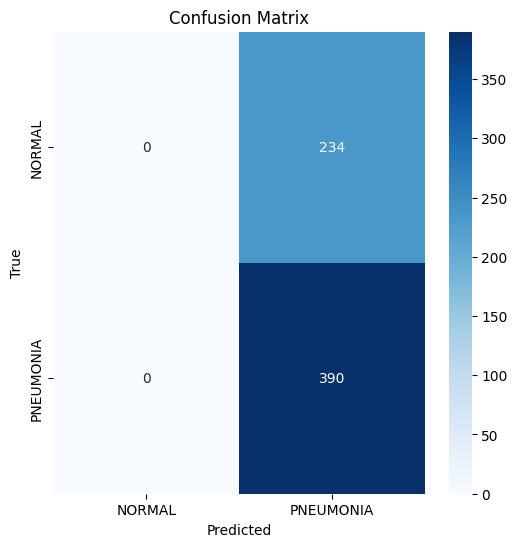

In [52]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 6.9. Predicción con los datos de validación.

In [53]:
# Evaluación después de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model_dn.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00         8
   PNEUMONIA       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

## 6.10. Matriz de conusión datos de validación

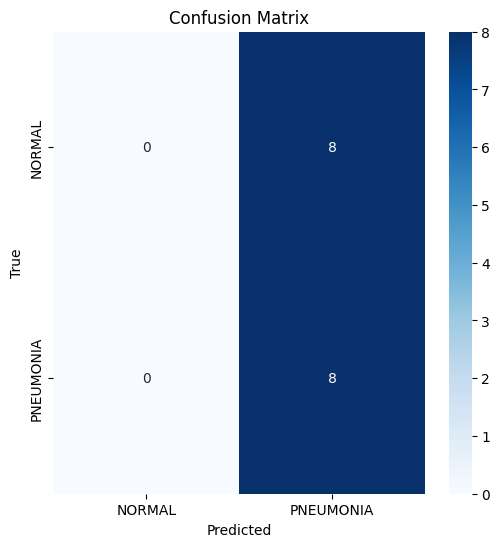

In [54]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 6.11. Curva ROC
### 6.11.1. Curva ROC con los datos de test

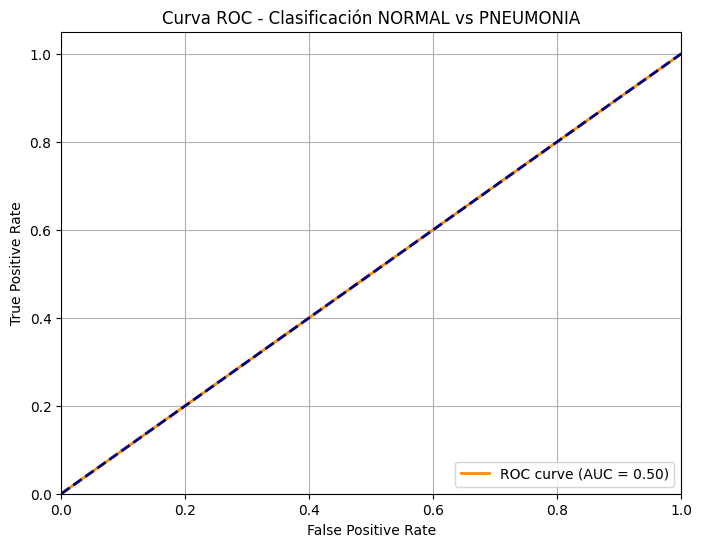

In [55]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 6.11.2. Curva ROC con los datos de validación.

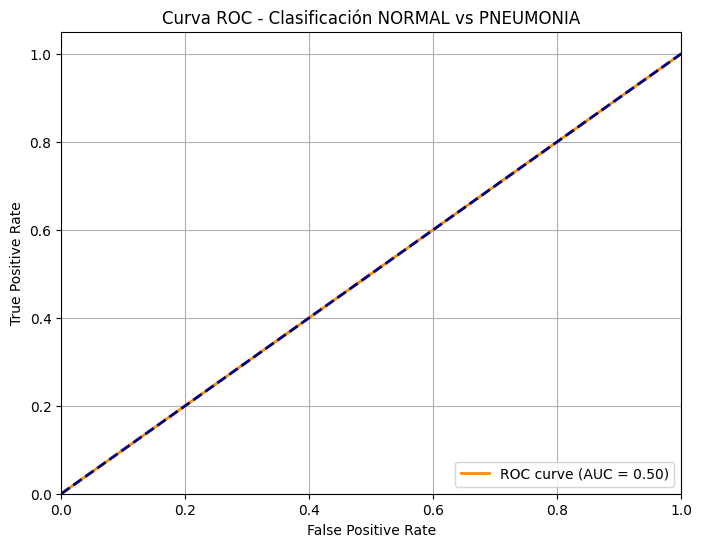

In [56]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 6.12. Distribución de errores.
### 6.12.1. Distribución de errores con los datos de test.

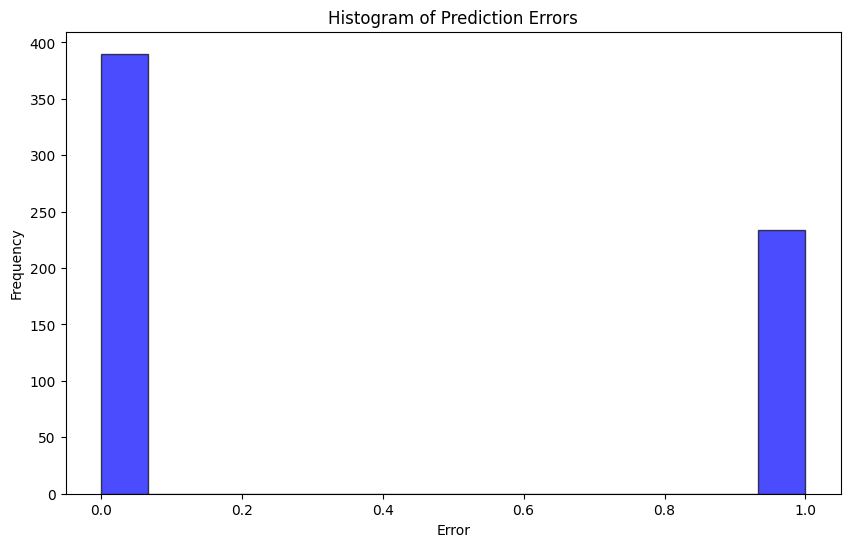

In [57]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

### 6.12.2 Distribución de errores con los datos de validación.

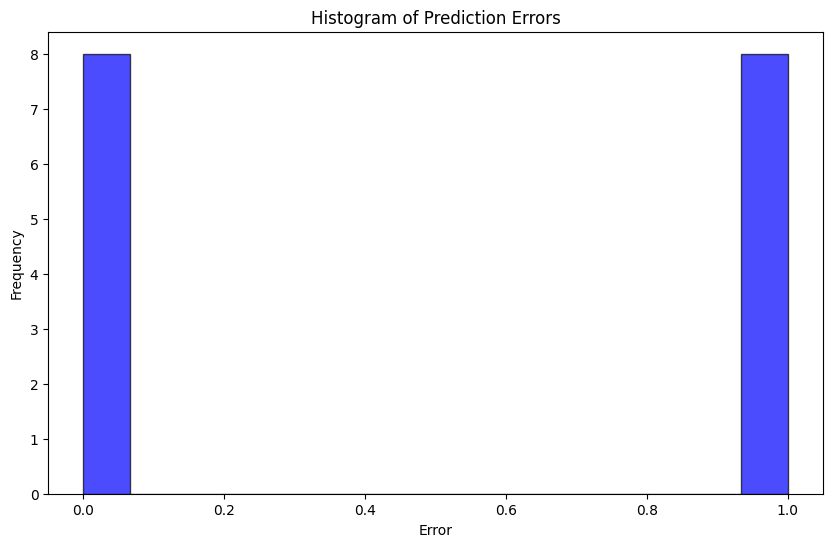

In [58]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 7. Modelo ResNet50 usando data aumentation a fin de intentar mejorar las métricas.
## 7.1. Modelo.

In [81]:
# Carga de la ResNet50 preentrenada (sin la última capa)
base_model_rs2 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model_rs2.trainable = False  # Congelar pesos

# Construcción del modelo final
model_rs2 = models.Sequential([
    base_model_rs2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


## 7.2 Resumen del modelo.

In [82]:
model_rs2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

# 7.3 Compilado y entrenamiento del modelo.

In [83]:
model_rs2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rs2 = model_rs2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30


c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - loss: 0.8652 - sparse_categorical_accuracy: 0.5053 - val_loss: 0.6630 - val_sparse_categorical_accuracy: 0.6250
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - loss: 0.6752 - sparse_categorical_accuracy: 0.5764 - val_loss: 0.6381 - val_sparse_categorical_accuracy: 0.6250
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - loss: 0.6085 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.6037 - val_sparse_categorical_accuracy: 0.7500
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - loss: 0.5753 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.5925 - val_sparse_categorical_accuracy: 0.6250
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - loss: 0.5528 - sparse_categorical_accuracy: 0.7753 - val_loss: 0.5634 - val_sparse_categorical_accuracy: 0.7500
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - loss: 0.5341 - sparse_categorical_accuracy: 0.7885 - val_loss: 0.5655 - val_sparse_categorical_accuracy: 0.6250
Epoch 7/3

## 7.4 Evaluación del modelo con los datos de test.

In [84]:
test_loss, test_acc = model_rs2.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 3.5618 - sparse_categorical_accuracy: 0.7016
Test accuracy: 0.375


## 7.5. Gráficos del comportamiento del modelo durante el entrenamiento.

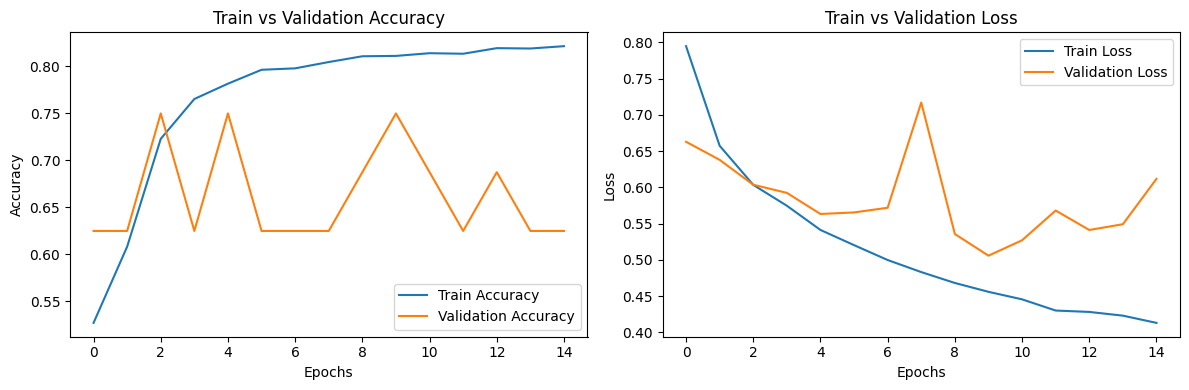

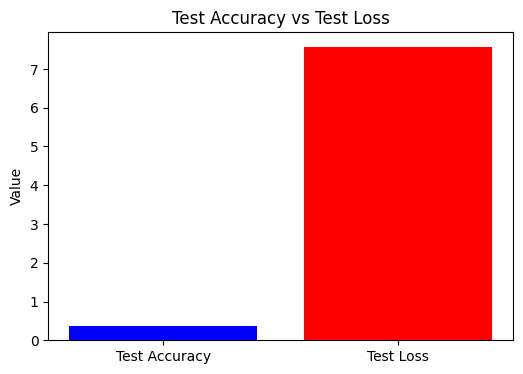

In [85]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rs2.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_rs2.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_rs2.history['loss'], label='Train Loss')
plt.plot(history_rs2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


## 7.6. Predicción con los datos de test

In [86]:
# Evaluación después de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model_rs2.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

## 7.7 Matriz de confusión con los datos de test.

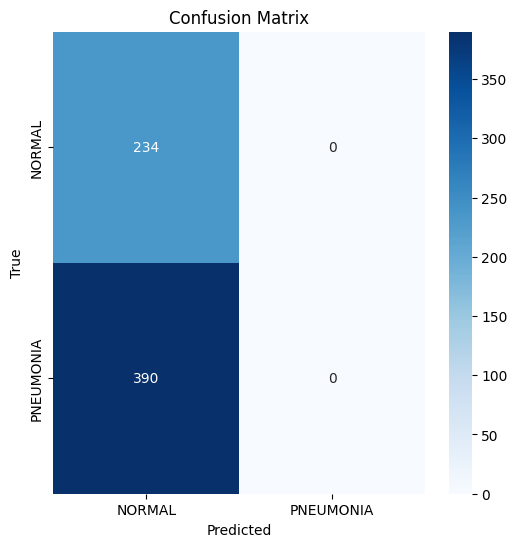

In [87]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 7.8. Predicción con los datos de validación.

In [88]:
# Evaluación después de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model_rs2.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
              precision    recall  f1-score   support

      NORMAL       0.50      1.00      0.67         8
   PNEUMONIA       0.00      0.00      0.00         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

## 7.9. Matriz de confusión con los datos de validación.

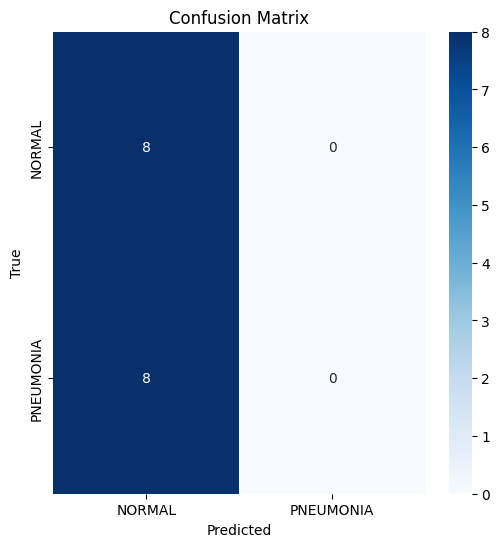

In [89]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 7.10. Curva ROC.
### 7.10.1. Curva ROC con los datos de test.

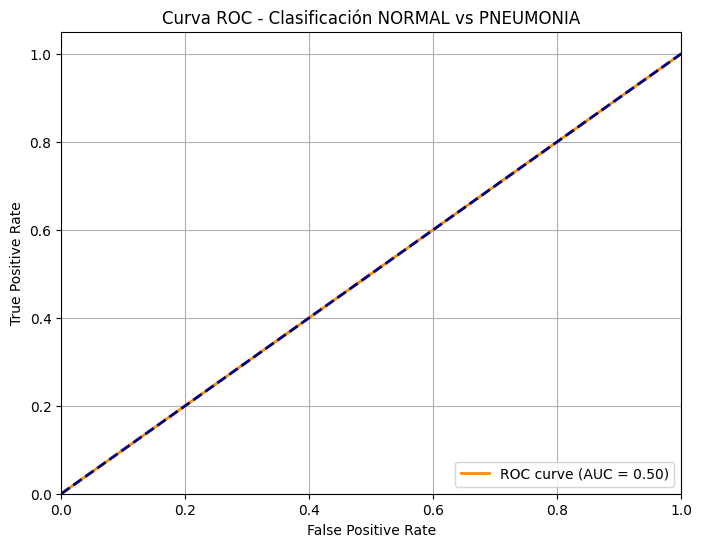

In [90]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 7.10.2. Curva ROC con los datos de validación.

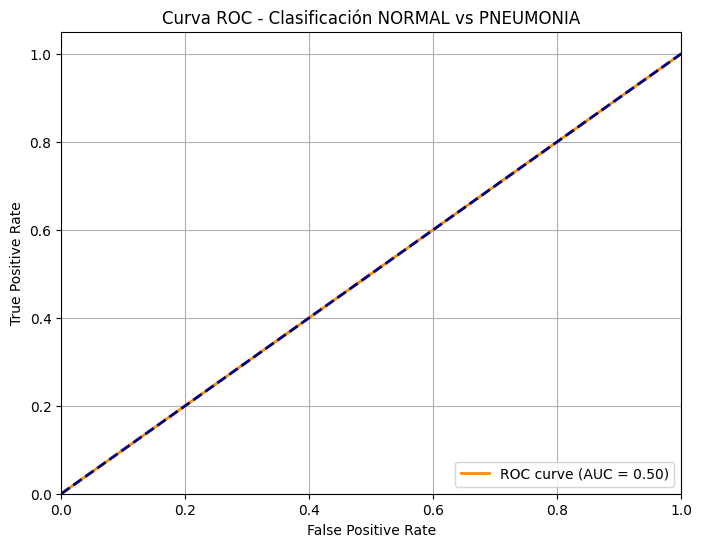

In [91]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 7.11. Distribución de errores con los datos de test.

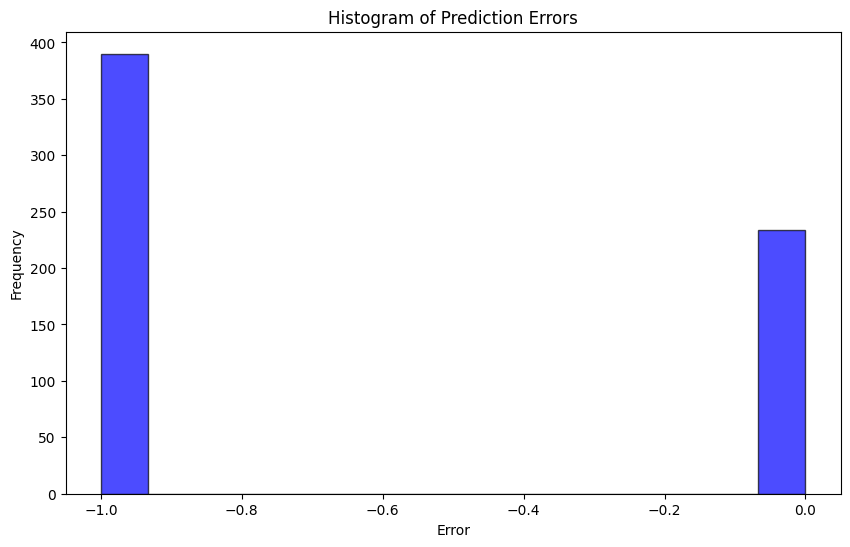

In [92]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

## 7.12. Distribución de errores con los datos de validación.

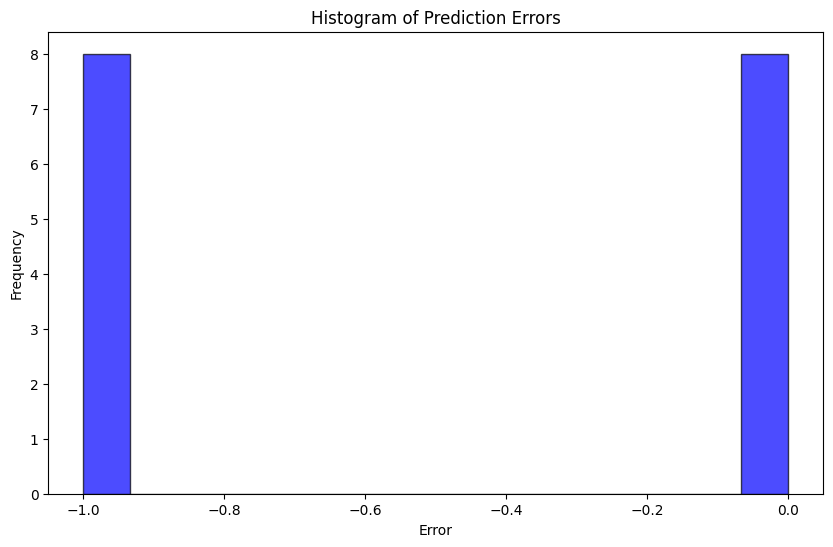

In [93]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

In [94]:
!pip freeze > requirements.txt